### Q1 

Apply iLQR to the differential drive vehicle. 

In [437]:
##import all the necessary packages
import math 
from math import sin 
from math import cos
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
from numpy.linalg import inv


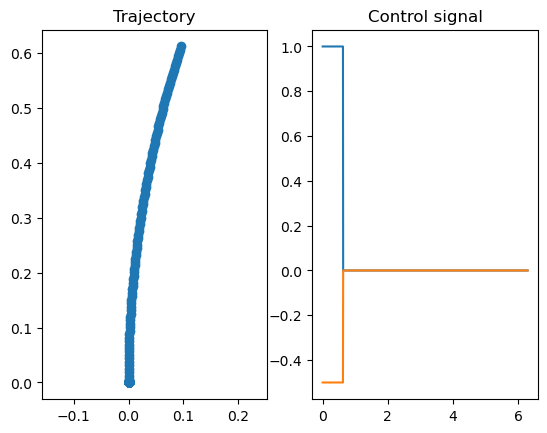

In [438]:
##Initialize our variables and create a reference trajectory--------------------------------------------
t = 2 * math.pi
timestep =  1000
dt = t/timestep
time = np.linspace(0,t,timestep)

#Initialize our time step array with 5 state variables at each time step [x_1, x_2, theta, u_1, u_2 ...]
traj_ref = np.zeros(5*time.size)
traj_ref[0:5] = np.array([0,0,math.pi/2,1,-0.5])

#Create our reference trajectory
for i in range(0,495,5):
    #Calculate the intial velocities.
    traj_ref[i + 5] = traj_ref[i] + dt * traj_ref[i + 3] * cos(traj_ref[i + 2])
    traj_ref[i + 6] = traj_ref[i + 1] + dt * traj_ref[i + 3] * sin(traj_ref[i + 2])
    traj_ref[i + 7] = traj_ref[i + 2] + dt * traj_ref[i + 4]
    traj_ref[i + 8] = traj_ref[i + 3]        
    traj_ref[i + 9] = traj_ref[i + 4]    
    
#Set the controls to 0 at the end.
traj_ref[-1], traj_ref[-2] = 0, 0

#Reshape our trajectory to be in the shape we want it to be 
traj_ref = np.reshape(traj_ref,(time.size,5))

##Create an optimal trajectory--------------------------------------------------------------------------
#Initalize our optimal trajectory
traj_optimal = np.array([0,0,math.pi/2])

#Create the optimal trajectory
for ii in time[1:]:
    traj_optimal = np.vstack((traj_optimal, np.array([(4/2*math.pi)*ii,0,math.pi/2])))

#Find the difference between the two trajectories. This essentially becomes our (x(t) - x_d(T))
traj_init = traj_ref[:,0:3]
traj_diff = traj_optimal - traj_init
controls = traj_ref[:,(3,4)]

##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(traj_ref[:,0], traj_ref[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(time, traj_ref[:,3])
axs[1].set_title("Control signal")
axs[1].plot(time, traj_ref[:,4], "tab:orange")

## iLQR implementation
When choosing the necessary parameters that we are going to be using in the algorithm, keep in mind that the parameters must fall within the following categories: 
$$
\alpha \in (0,0.5) \\
\beta \in (0,1)
$$



In [439]:
##Setup our weight matrices --------------------------------------------------------------------
Q = np.diag(np.array([10, 10, 1]))

R = np.diag(np.array([10, 10])) #The way these function they give more weight to the values that have higher values.

P_1 = np.diag(np.array([10, 10, 1])) #For functions with no remainder, then we can make P1 = Q 

alpha = 0.4         #Recommended choices are 0.4 and 10E-4
beta = 0.7          #Recommended choice is 0.7 but ultimately up to designer discretion
epsilon = 10**-3    #This is the threshold value that we can assign

#Create a dictionary with keys to use.
time_stamp = dict(zip(time,traj_ref))
print(time_stamp.get(time[-1]))

##Initialize A(D_1f(x,u)) and B (D_2f(x,u)) to create the f(s,u)
def A(t): 
    ##A is function that takes in a timestamp and subsequently accesses the time_stamp dictionary to get the values of theta, x, y, u1, u2 at that time. 
    curr = time_stamp.get(t)    
    x = curr[0]
    y = curr[1]
    theta = curr[2]
    u1 = curr[3]
    return np.array([[0, 0, -1*u1*sin(theta)],
                     [0, 0, u1*cos(theta)],
                     [0, 0, 0]
                     ])

def B(t):
    curr = time_stamp.get(t)
    x = curr[0]
    y = curr[1]
    theta = curr[2]
    return np.array([[cos(theta), 0],
                     [sin(theta), 0],
                     [0, 1]
                     ])

def a(s,Q):
    return np.array([[Q @ s[0]],
                     [Q @ s[1]],
                     [Q @ s[2]]])

def b(t,R):
    curr = time_stamp.get(t)
    u = np.array([[curr[3]], [curr[4]]])
    return R @ u

#If we want to use solve_ivp we need to be able to calculate A(t) and B(t) as a function of time. 
# def riccati(t,y):
#     print(t)
#     y = np.reshape(y, (3,3))
#     ans = -1 * y @ A(t) - A(t).T @ y - y @ B(t) @ inv(R) @ B(t).T @ y - Q
#     return np.reshape(ans,(9,))

# rk45 = solve_ivp(riccati,[time[-1],time[0]],P_1.flatten(), t_eval= np.flip(time), vectorized=True) 

#This is used to solve the backward propogation of P using Euler's Integration Method.
def euler(P,A,B,Q,R,time,dt):
    #Create an array to hold all the possible values of P(t)
    ans = np.ndarray((9,time.size))

    #Add the terminal condition to the array
    ans[:,-1] = P.flatten()

    #Solve for the P(t) term using the backwards propogation Euler Method.
    for i in reversed(range(1,len(time))):  
        #Solve the current slope. Note that this is -1 * \dot{P}(t)
        PDot = P @ A(time[i]) + A(time[i]).T @ P - P @ B(time[i]) @ inv(R) @ B(time[i]).T @ P + Q

        #Solve for the next iteration and add it to the answers array. 
        P = P + PDot * dt
        ans[:,i-1] = P.flatten()

    return ans

def objective(x_traj,x_ref,u,Q,R,P,time):
    #Create the cost integral and calculate the interior of the integral at all time steps. 
    J = np.ndarray((time.size))

    #Calculate the interior of the integral at each time step. 
    for ii in range(len(time)):
        #The formula is modified because the expectation is that x is originally a column vector.
        #The input control vector is also input as a [1,2] vector as opposed to a [2,1]
        J[ii] = 0.5 * (x_traj[ii,:]- x_ref[ii,:]) @ Q @ (x_traj[ii,:] - x_ref[ii,:]).T + 0.5 * u[ii,:] @ R @ u[ii,:].T  
    
    #Find the sum total using the Simpson function. 
    cost = simpson(J,time) + 0.5 * (x_traj[-1,:] - x_ref[-1,:]) @ P @ (x_traj[-1,:] - x_ref[-1,:]).T
    
    return cost

def z_func(z0, A, B, R, P, b, time, dt):
    #Make sure that z0 has a [3,1] shape. 
    z = np.zeros((3, time.size))

    #Reshape the vector into a (3,1) in order to be able to matrix multiply. Update it as the current z. 
    curr_z = np.reshape(z0, (3,1))

    #Calculate the next z based on the current zdot using Eulers. 
    for ii in range(len(time)-1): 
        zdot = A(time[ii]) @ curr_z - B(time[ii]) @ inv(R) @ B(time[ii]).T @ P[:,ii].reshape(3,3) @ curr_z - B(time[ii]) @ inv(R) @ b(time[ii],R)

        #Flatten it because it needs a vector to be able to do row/column assigment
        z[:,ii+1] = (curr_z + zdot * dt).flatten()   

        #Return an array of column vectors that correspond to z.
    return z

def v_func(z, A, B, R, P, b, time):
    v = np.zeros((2,time.size))

    for ii in range(len(time)):
        v_now = (-1 * inv(R) @ B(time[ii]).T @ P[:,ii].reshape(3,3) @ z[:,ii]).reshape(2,1) - inv(R) @ b(time[ii],R)
        v[:,ii] = v_now.reshape(2,)
    #Return a column vector that corresponds to v across the entire trajectory. 
    return v


# ##Iterative Linear Quadratic Control ----------------------------------------------------------- 

#Get into the while loop by initiating the counters.
xi = 1
i = 0 

#Set the update trajectory to the inital trajectory
traj_update = traj_init
print(time_stamp.get(time[-1]))
ob_Arr = []

while xi > epsilon:
    #Find the cost of the trajectory. Please note that traj_init/optimal = [x, y, theta] and controls = [u1, u2]
    cost = objective(traj_update[:,0:3],traj_optimal,controls,Q,R,P_1,time)

    # Start solving the Riccati Equations from the terminal condition P(T) = P_1
    P_arr = euler(P_1,A,B,Q,R,time,dt)

    #Solve for the z variable using the z_Dot function
    z = z_func(np.zeros(3),A,B,R,P_arr,b, time, dt)
    v = v_func(z, A, B, R, P_arr, b, time)

    ##Find the directional derivative in the direction of z and v 
    #Now that we have z based on v, we can solve the directional derivative.
    #Initialize an array for the integral at each timestep.
    integral = np.zeros((time.size))

    #Find the difference between the two current trajectories. 
    x = traj_update[:,0:3] - traj_optimal

    for jj in range(len(time)):
        #Calculate the integral at each timestep. 
        integral[jj] = (x[jj,:,None].T @ Q @ z[:,jj,None]+ controls[jj,:,None].T @ R @ v[:,jj,None])[0]  

    #Sum the integral and the terminal cost to get the directional derivative total.
    dJ= (simpson(integral,time) + x[-1,:,None].T @ P_arr[:,jj].reshape(3,3) @ z[:,-1,None])[0,0]

    #Implement Armijo Gradient Descent Rule
    n = 0
    gamma = beta ** n 

    #Update the xi variable
    xi = abs(dJ)
    
    while objective(traj_update[:,0:3],traj_optimal,controls,Q,R,P_1,time) > cost + alpha * gamma * dJ:
        #Compute the controls vectors.
        controls = controls + gamma * v.T

        #Find the new x points based on the updated controls 
        temp = np.zeros(5*time.size)
        temp[0:5] = np.concatenate((np.array([0,0,math.pi/2]), controls[0,:]))

        #iterator initialization
        jjj = 1
        for j in range(0,495,5):
            #Calculate the new velocities.
            temp[j + 5] = temp[j] + dt * temp[j + 3] * cos(temp[j + 2])
            temp[j + 6] = temp[j + 1] + dt * temp[j + 3] * sin(temp[j + 2])
            temp[j + 7] = temp[j + 2] + dt * temp[j + 4]
            temp[j + 8] = controls[jjj, :][0]        
            temp[j + 9] = controls[jjj, :][1]
            jjj += 1

        #Creation of the new trajectory.
        traj_update = np.reshape(temp,(time.size,5))
        
        #Add the objective values to the array.
        ob_Arr.append(objective(traj_update[:,0:3],traj_optimal,controls,Q,R,P_1,time))

        #update the Armijo counter step size and the gamma 
        n += 1 
        gamma = beta ** n 
    
    #Update our dictionary with the new keys. 
    time_stamp = dict(zip(time,traj_update))

    #Update our iterative counter.
    i += 1 

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


$$
\text{The objective function of the equation we are solving is:}\\ \\
\\
J = \int_0^T0.5(x-x_{d})^T Q(x-x_d) + 0.5u^TRudt + 0.5(x(T) - x_d(T))^TP_1(x(T) - x_d(T))
\\
\text{Note that the terminal cost of this function} \: m_x(T) = p(T) = p_1 
\\
\newline
$$

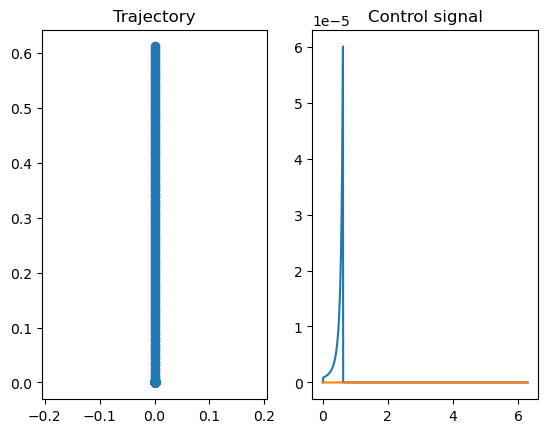

In [440]:
##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(traj_update[:,0], traj_ref[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(time, traj_update[:,3])
axs[1].set_title("Control signal")
axs[1].plot(time, traj_update[:,4], "tab:orange")

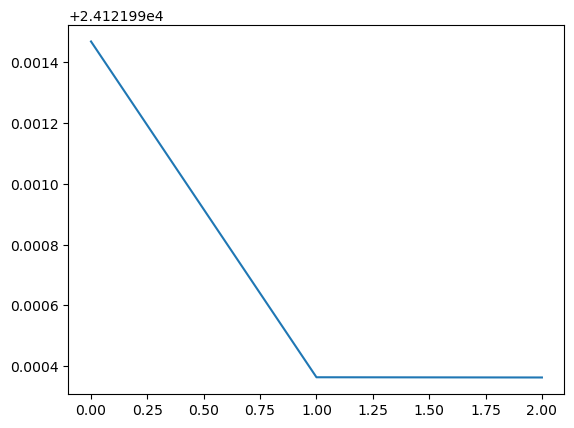

In [441]:
##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots()
#Plotting the reference trajectory
axs.plot(ob_Arr[0:100])




In [442]:
#If we want to use solve_ivp we need to be able to calculate A(t) and B(t) as a function of time. 
def riccati(t,y):
    y = np.reshape(y, (3,3))
    ans = y @ A1(t,time) + A1(t,time).T @ y - y @ B1(t,time) @ inv(R) @ B1(t,time).T @ y + Q
    return np.reshape(ans,(9,))

def A1(t,time): 
    #Find the closest time that we need. 
    index = np.absolute(time-t).argmin() 
    #A1 is function that takes in a timestamp and subsequently accesses the time_stamp dictionary to get the values of theta, x, y, u1, u2 at that time. 
    curr = time_stamp.get(time[index]) 
    x = curr[0]
    y = curr[1]
    theta = curr[2]
    u1 = curr[3]
    return np.array([[0, 0, -1*u1*sin(theta)],
                     [0, 0, u1*cos(theta)],
                     [0, 0, 0]
                     ])

def B1(t,time):
    #Find the closest time that we need. 
    index = np.absolute(time-t).argmin() 
    #A1 is function that takes in a timestamp and subsequently accesses the time_stamp dictionary to get the values of theta, x, y, u1, u2 at that time. 
    curr = time_stamp.get(time[index]) 
    x = curr[0]
    y = curr[1]
    theta = curr[2]
    return np.array([[cos(theta), 0],
                     [sin(theta), 0],
                     [0, 1]
                     ])

rk45 = solve_ivp(riccati,[time[-1],time[0]],P_1.flatten(), t_eval= np.flip(time), vectorized=True) 
np.flip(time)

array([6.28318531, 6.27689583, 6.27060636, 6.26431688, 6.25802741,
       6.25173793, 6.24544846, 6.23915898, 6.23286951, 6.22658003,
       6.22029056, 6.21400108, 6.20771161, 6.20142214, 6.19513266,
       6.18884319, 6.18255371, 6.17626424, 6.16997476, 6.16368529,
       6.15739581, 6.15110634, 6.14481686, 6.13852739, 6.13223791,
       6.12594844, 6.11965896, 6.11336949, 6.10708001, 6.10079054,
       6.09450106, 6.08821159, 6.08192211, 6.07563264, 6.06934316,
       6.06305369, 6.05676422, 6.05047474, 6.04418527, 6.03789579,
       6.03160632, 6.02531684, 6.01902737, 6.01273789, 6.00644842,
       6.00015894, 5.99386947, 5.98757999, 5.98129052, 5.97500104,
       5.96871157, 5.96242209, 5.95613262, 5.94984314, 5.94355367,
       5.93726419, 5.93097472, 5.92468524, 5.91839577, 5.9121063 ,
       5.90581682, 5.89952735, 5.89323787, 5.8869484 , 5.88065892,
       5.87436945, 5.86807997, 5.8617905 , 5.85550102, 5.84921155,
       5.84292207, 5.8366326 , 5.83034312, 5.82405365, 5.81776